# Waves in magnetized Plasmas: R-waves and L-Waves

To study electromagnetic waves in a magnetized plasma, in particular waves propagating along the applied magnetic field, we initialize the simulation with a uniform thermal plasma, effectively injecting waves of all possible wavelengths into the simulation.

The external magnetic field is applied along the `x` direction, and can be controlled through the `Bx0` variable:

In [1]:
# Add zpic library to path
import sys
sys.path.append("../../lib")

import em1ds as zpic

electrons = zpic.Species( "electrons", -1.0, ppc = 64, uth=[0.005,0.005,0.005])

sim = zpic.Simulation( nx = 1000, box = 100.0, dt = 0.0999, species = electrons )
sim.emf.solver_type = 'PSATD'

#Bx0 = 0.5
#Bx0 = 1.0
Bx0 = 2.0



ext = zpic.ExternalField(B_type = 'uniform',B_0= [Bx0, 0.0, 0.0])

sim.emf.set_ext_fld( ext )

We run the simulation up to a fixed number of iterations, controlled by the variable `niter`, storing the value of the EM fields $E_y$ and $E_z$ at every timestep so we can analyze them later:

In [2]:
import numpy as np

niter = 1000

Ez_t = np.zeros((niter,sim.nx))

tmax = niter * sim.dt

print("\nRunning simulation up to t = {:g} ...".format(tmax))
while sim.t <= tmax:
    print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
    Ez_t[sim.n,:] = sim.emf.Ez
    sim.iter()

print("\nDone.")


Running simulation up to t = 99.9 ...
n = 999, t = 99.8001
Done.


## EM Waves

As discussed above, the simulation was initialized with a broad spectrum of waves through the thermal noise of the plasma. We can see the noisy fields in the plot below:

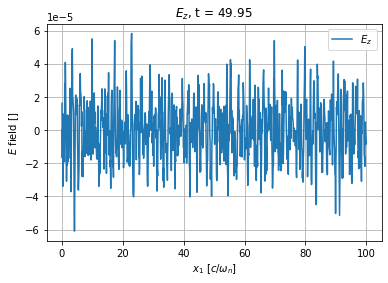

In [3]:
import matplotlib.pyplot as plt

iter = sim.n//2
plt.plot(np.linspace(0, sim.box, num = sim.nx),Ez_t[iter,:], label = "$E_z$")
plt.grid(True)
plt.xlabel("$x_1$ [$c/\omega_n$]")
plt.ylabel("$E$ field []")
plt.title("$E_z$, t = {:g}".format( iter * sim.dt))
plt.legend()
plt.show()

## R/L-Waves

To analyze the dispersion relation of the R/L-waves we use a 2D (Fast) Fourier transform of $E_z(x,t)$ field values that we stored during the simulation. The plot below shows the obtained power spectrum alongside the theoretical prediction for the L-wave and the two solutions for the R-wave.

Since the dataset is not periodic along $t$ we apply a windowing technique (Hanning) to the dataset to lower the background spectrum, and make the dispersion relation more visible.

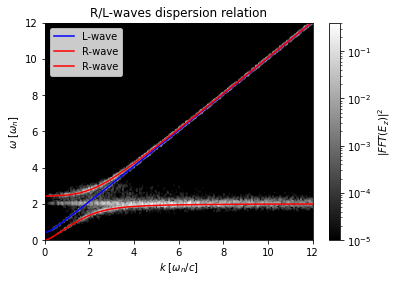

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# (omega,k) power spectrum

win = np.hanning(niter)
for i in range(sim.nx):
    Ez_t[:,i] *= win

sp = np.abs(np.fft.fft2(Ez_t))**2
sp = np.fft.fftshift( sp )

k_max = np.pi / sim.dx
omega_max = np.pi / sim.dt

plt.imshow( sp, origin = 'lower', norm=colors.LogNorm(vmin = 1e-5),
           extent = ( -k_max, k_max, -omega_max, omega_max ),
           aspect = 'auto', cmap = 'gray')

plt.colorbar().set_label('$|FFT(E_z)|^2$')

# Theoretical curves
wC = Bx0
wR = 0.5*(np.sqrt( wC**2 + 4) + wC)
wL = 0.5*(np.sqrt( wC**2 + 4) - wC)

w = np.linspace(wL, omega_max, num = 512)
k = w * np.sqrt( 1.0 - 1.0/(w**2 * (1+wC/w) ) )
plt.plot( k, w, label = "L-wave", color = 'b' )

w = np.linspace(wR + 1e-6, omega_max, num = 512)
k = w * np.sqrt( 1.0 - 1.0/(w**2 * (1-wC/w) ) )
plt.plot( k, w, label = "R-wave", color = 'r')

w = np.linspace(1e-6, wC - 1e-6, num = 512)
k = w * np.sqrt( 1.0 - 1.0/(w**2 * (1-Bx0/w) ) )
plt.plot( k, w, label = "R-wave", color = 'r' )


plt.ylim(0,12)
plt.xlim(0,12)
plt.xlabel("$k$ [$\omega_n/c$]")
plt.ylabel("$\omega$ [$\omega_n$]")
plt.title("R/L-waves dispersion relation")

plt.legend()

plt.show()
